# Project: Data Analysis

In this project, I want to find the most frequent topics from unstructured complaint texts using Natural Language Processing (NLP) techniques. I selected the dataset “Air France Reviews” from Kaggle, which includes unstructured customer feedback about airline services. These reviews often express detailed complaints and opinions about flight delays, food, staff, and comfort, making them ideal for identifying key topics through NLP.

## Text Preprocessing
* Removing punctuation
* Lowercasing
* Eliminating Stopwords
* Lemmatization

## Vectorization Techniques
* TF-IDF via Sklearn
* BERT

## Topic Extraction
* LDA
* BERTopic

## Notebook Imports

In [1]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9.90:
      Successfully uninstalled nvidia-curand-cu12-10.3.9.90
  Attemptin

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Transformers
import transformers
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer

# Gensim
from gensim.models.ldamodel import LdaModel

# Pytorch 
import torch
import torch.nn as nn

2025-05-14 12:19:22.003065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747225162.263648      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747225162.342002      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Loading

In [3]:
dataset = pd.read_csv("/kaggle/input/air-france-reviews-dataset/airfrance_tripadvisor_reviews.csv")
dataset.head()

,rating,title,text,publishedDate
0,1,WORST AIRLINE,I travel a lot - and I travel often. Last week...,2024-11-13
1,1,Terrible experience with Airfrance,"This review is regarding flight AF185, we book...",2024-11-13
2,1,Extremely Disappointing Experience with Air Fr...,I recently flew with Air France on flight #185...,2024-11-12
3,1,Horrible,Wow!!! What a horrible experience!! I've alway...,2024-11-11
4,1,The Worst Flight Experience I’ve Ever Had,I spent a fantastic 10-day vacation in Hong Ko...,2024-11-11


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating         2560 non-null   int64 
 1   title          2560 non-null   object
 2   text           2560 non-null   object
 3   publishedDate  2560 non-null   object
dtypes: int64(1), object(3)
memory usage: 80.1+ KB


In [5]:
dataset.duplicated().sum()

0

In [6]:
dataset.shape

(2560, 4)

## Data Visualization

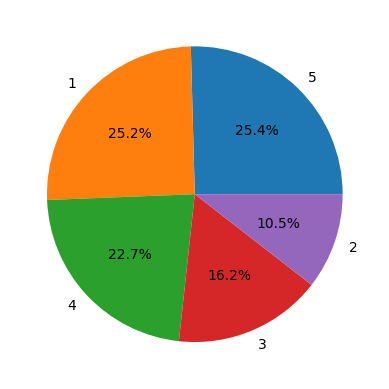

In [7]:
rating = dataset['rating'].value_counts()
labels = rating.keys()
plt.pie(rating, labels=labels, autopct='%1.1f%%')
plt.show()

## Data Cleaning

In [8]:
def preprocess_text(text: str, stopwords=set(stopwords.words('english')), wnl=WordNetLemmatizer()):
    
    """
    Preprocesses the input text by tokenizing, removing stopwords and punctuation, and lemmatizing the words.
    
    Args:
        text (str): The input text to be preprocessed.
        stopwords (set, optional): A set of stopwords to be removed from the text. Defaults to nltk's English stopwords.
        wnl (WordNetLemmatizer, optional): An instance of WordNetLemmatizer for lemmatizing words. Defaults to an instance of WordNetLemmatizer.
        
    Returns:
        list or str: The preprocessed text. 
    """
    
    # Tokenising
    words = word_tokenize(text.lower())
    
    # Removing Stopwords & Punctuation
    filtered_text = [word for word in words if word not in stopwords and word.isalpha()]
    
    # Lemmatization
    preprocessed_text = [wnl.lemmatize(word) for word in filtered_text]
    
    return preprocessed_text

In [9]:
dataset['text'] = dataset['text'].apply(preprocess_text)
dataset.head()

,rating,title,text,publishedDate
0,1,WORST AIRLINE,"[travel, lot, travel, often, last, week, flew,...",2024-11-13
1,1,Terrible experience with Airfrance,"[review, regarding, flight, booked, economy, f...",2024-11-13
2,1,Extremely Disappointing Experience with Air Fr...,"[recently, flew, air, france, flight, hong, ko...",2024-11-12
3,1,Horrible,"[wow, horrible, experience, always, flown, por...",2024-11-11
4,1,The Worst Flight Experience I’ve Ever Had,"[spent, fantastic, vacation, hong, kong, famil...",2024-11-11


In [10]:
dataset.drop(['title', 'publishedDate'], axis=1, inplace=True)
dataset.head()

,rating,text
0,1,"[travel, lot, travel, often, last, week, flew,..."
1,1,"[review, regarding, flight, booked, economy, f..."
2,1,"[recently, flew, air, france, flight, hong, ko..."
3,1,"[wow, horrible, experience, always, flown, por..."
4,1,"[spent, fantastic, vacation, hong, kong, famil..."


## Text Vectorization

### Option 1: TF-IDF via Sklearn → based on word **frequency**

In [11]:
dataset['cleaned_text'] = dataset['text'].apply(" ".join)
documents = [item for item in dataset['cleaned_text']]

In [12]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=10, ngram_range=(1,2))
vectors = vectorizer.fit_transform(documents)
vectors.shape

(2560, 2444)

In [13]:
feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()

In [14]:
all_keywords = []

for document in denselist:
    x = 0
    keywords = []
    for word in document:
        if word > 0:
            keywords.append(feature_names[x])
        x = x + 1
    all_keywords.append(keywords)

In [15]:
print(documents[1])
print(all_keywords[1])

review regarding flight booked economy flex flight choose seat flight even though skypriority stayed inline around hour overly vague information regarding delay end get back u say seat relocated worse one halal meal given u extremely bland even offered drink accompany meal compared others specify wanted halal meal staff also overly rude daughter compared passenger reason could wearing hijab completely unbearable overall experience airfrance definitely unforgettable one negative sense unfortunately never board plane logo life
['airfrance', 'also', 'around', 'around hour', 'back', 'board', 'board plane', 'booked', 'choose', 'choose seat', 'compared', 'completely', 'could', 'daughter', 'definitely', 'delay', 'drink', 'economy', 'end', 'even', 'even though', 'experience', 'extremely', 'flight', 'flight booked', 'flight even', 'get', 'get back', 'given', 'hour', 'information', 'life', 'meal', 'negative', 'never', 'offered', 'one', 'others', 'overall', 'overall experience', 'passenger', 'pla

In [16]:
tfidf_df = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,ability,able,able get,aboard,absolute,absolutely,accept,acceptable,access,accommodating,...,wrote,year,year ago,year old,yes,yet,york,young,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.045582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


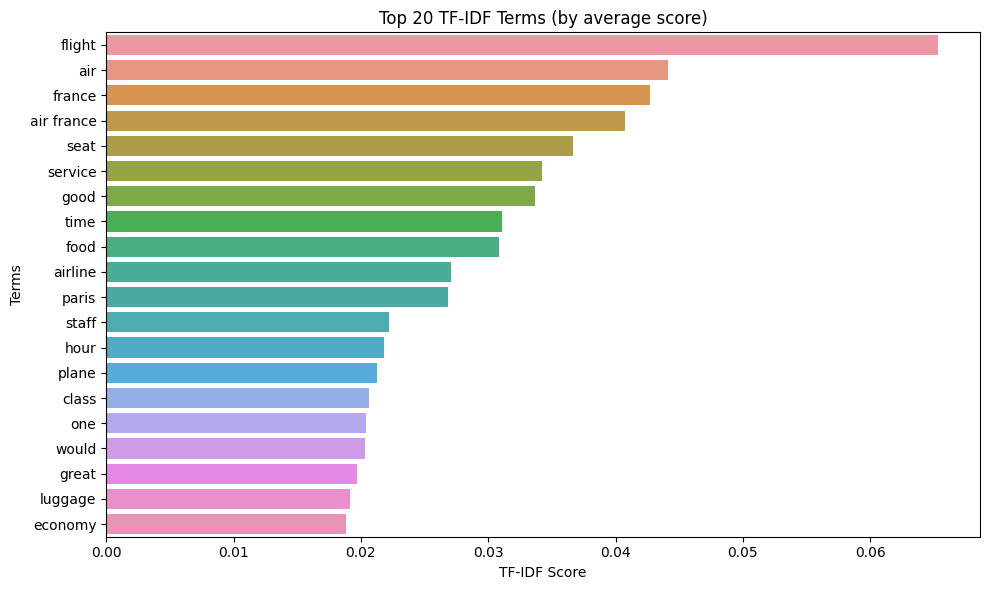

In [17]:
tfidf_means = np.asarray(vectors.mean(axis=0)).flatten()
top_indices = tfidf_means.argsort()[::-1][:20]
top_terms = [feature_names[i] for i in top_indices]
top_scores = tfidf_means[top_indices]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_scores, y=top_terms)
plt.title("Top 20 TF-IDF Terms (by average score)")
plt.xlabel("TF-IDF Score")
plt.ylabel("Terms")
plt.tight_layout()
plt.show()

### Option 2: BERT → based on **meaning**

In [18]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(documents)
embeddings.shape

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/80 [00:00<?, ?it/s]

(2560, 384)

In [19]:
# from transformers import AutoTokenizer, BertModel
# import torch

# tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
# model = BertModel.from_pretrained("google-bert/bert-base-uncased")

# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# outputs = model(**inputs)

# last_hidden_states = outputs.last_hidden_state

## Topic Modelling

### Option 1: Latent Dirichlet Allocation

### Option 2: BertTopic